In [ ]:
#%% 

import re
import six
import math
import lmdb
import numpy as np
from PIL import Image, ImageDraw

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from IPython.display import display

# MPS Fallback 활성화 (GPU 활용 + CTC Loss 호환성)
import os

# 환경 변수를 더 확실하게 설정
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'
os.environ['PYTORCH_MPS_HIGH_WATERMARK_RATIO'] = '0.0'

print("✅ MPS Fallback이 활성화되었습니다.")

# 디바이스 설정 (MPS 사용하되 CTC Loss는 CPU fallback)
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("🎯 MPS GPU 사용 (CTC Loss는 CPU fallback)")
    print("💡 Convolution, LSTM 등은 GPU에서 가속화됩니다!")
else:
    device = torch.device("cpu")
    print("ℹ️ MPS 사용 불가능, CPU 사용")

print(f"사용 중인 디바이스: {device}")

✅ MPS Fallback이 활성화되었습니다.
🎯 MPS GPU 사용 (CTC Loss는 CPU fallback)
💡 Convolution, LSTM 등은 GPU에서 가속화됩니다!
사용 중인 디바이스: mps


In [ ]:
# %%

import os

data_dir = "/Users/gwanghunlee/ocr/data/extracted/data_lmdb_release"
os.chdir(data_dir)

print(data_dir)

TRAIN_DATA_PATH = data_dir + '/training/MJ/MJ_train'
VALID_DATA_PATH = data_dir + '/training/MJ/MJ_valid'
TEST_DATA_PATH  = data_dir + '/training/MJ/MJ_test'

print(TRAIN_DATA_PATH)# %%

/Users/gwanghunlee/ocr/data/extracted/data_lmdb_release
/Users/gwanghunlee/ocr/data/extracted/data_lmdb_release/training/MJ/MJ_train


original image width:72, height:31
target_img_size:(74, 32)
display img shape:(74, 32, 3)
label:Lube


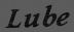

original image width:82, height:31
target_img_size:(84, 32)
display img shape:(84, 32, 3)
label:Spencerian


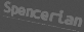

original image width:115, height:31
target_img_size:(100, 32)
display img shape:(100, 32, 3)
label:accommodatingly


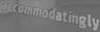

original image width:140, height:31
target_img_size:(100, 32)
display img shape:(100, 32, 3)
label:CARPENTER


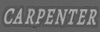

In [ ]:
# %%

from IPython.display import display

# env에 데이터를 불러올게요
# lmdb에서 데이터를 불러올 때 env라는 변수명을 사용하는게 일반적이에요
env = lmdb.open(TRAIN_DATA_PATH,
                max_readers=32,
                readonly=True,
                lock=False,
                readahead=False,
                meminit=False)

# 불러온 데이터를 txn(transaction)이라는 변수를 통해 엽니다
# 이제 txn변수를 통해 직접 데이터에 접근 할 수 있어요
with env.begin(write=False) as txn:
    for index in range(1, 5):
        # index를 이용해서 라벨 키와 이미지 키를 만들면
        # txn에서 라벨과 이미지를 읽어올 수 있어요
        label_key = 'label-%09d'.encode() % index
        label = txn.get(label_key).decode('utf-8')
        img_key = 'image-%09d'.encode() % index
        imgbuf = txn.get(img_key)
        buf = six.BytesIO()
        buf.write(imgbuf)
        buf.seek(0)

        # 이미지는 버퍼를 통해 읽어오기 때문에
        # 버퍼에서 이미지로 변환하는 과정이 다시 필요해요
        try:
            img = Image.open(buf).convert('RGB')

        except IOError:
            img = Image.new('RGB', (100, 32))
            label = '-'

        # 원본 이미지 크기를 출력해 봅니다
        width, height = img.size
        print('original image width:{}, height:{}'.format(width, height))

        # 이미지 비율을 유지하면서 높이를 32로 바꿀거에요
        # 하지만 너비를 100보다는 작게하고 싶어요
        target_width = min(int(width*32/height), 100)
        target_img_size = (target_width,32)
        print('target_img_size:{}'.format(target_img_size))
        img = np.array(img.resize(target_img_size)).transpose(1,0,2)

        # 이제 높이가 32로 일정한 이미지와 라벨을 함께 출력할 수 있어요
        print('display img shape:{}'.format(img.shape))
        print('label:{}'.format(label))
        display(Image.fromarray(img.transpose(1,0,2).astype(np.uint8)))

In [ ]:
# %%

class MJDataset(Dataset):
    # 객체를 초기화 할 때 lmdb를 열어 env에 준비해둡니다
    # 또, lmdb에 있는 데이터 수를 미리 파악해둡니다
    def __init__(
        self,
        dataset_path,
        label_converter,
        img_size=(100, 32),
        max_text_len=22,
        character="",
    ):
        super().__init__()
        self.label_converter = label_converter
        self.img_size = img_size
        self.max_text_len = max_text_len
        self.character = character

        # lmdb open
        self.env = lmdb.open(dataset_path,max_readers=32,readonly=True,lock=False,readahead=False,meminit=False)
        with self.env.begin(write=False) as txn:
            self.num_samples = int(txn.get("num-samples".encode()))
            self.index_list = [idx + 1 for idx in range(self.num_samples)]

    def __len__(self):
        return self.num_samples

    # index에 해당하는 image와 label을 읽어옵니다
    # 위에서 사용한 코드와 매우 유사합니다
    # label을 조금 더 다듬는 것이 약간 다릅니다
    def __getitem__(self, idx):
        index = self.index_list[idx]
        with self.env.begin(write=False) as txn:
            label_key = f"label-{index:09d}".encode()
            label = txn.get(label_key).decode("utf-8")

            img_key = f"image-{index:09d}".encode()
            imgbuf = txn.get(img_key)

            buf = six.BytesIO()
            buf.write(imgbuf)
            buf.seek(0)

            try:
                img_pil = Image.open(buf).convert("RGB")
            except IOError:
                img_pil = Image.new("RGB", self.img_size)
                label = "-"

        orig_w, orig_h = img_pil.size
        target_width = min(int(orig_w * self.img_size[1] / orig_h), self.img_size[0])
        target_img_size = (target_width, self.img_size[1])
        img_pil = img_pil.resize(target_img_size)

        img = np.array(img_pil)
        img = img.transpose(2, 0, 1)

        padded_img = np.zeros((3, self.img_size[1], self.img_size[0]), dtype=np.float32)
        c, h, w = img.shape
        padded_img[:, :h, :w] = img

        # 레이블 전처리
        label = label.upper()
        out_of_char = f"[^{self.character}]"
        label = re.sub(out_of_char, "", label)
        label = label[: self.max_text_len]

        encoded_label = self.label_converter.encode(label)

        return padded_img, encoded_label, len(encoded_label), label

In [ ]:
# %%

def collate_fn(batch):
    imgs, encoded_labels, label_lens, raw_labels = zip(*batch)

    imgs_tensor = torch.tensor(np.stack(imgs, axis=0), dtype=torch.float32)

    max_len = max(label_lens)
    labels_padded = torch.zeros(len(batch), max_len, dtype=torch.long)
    for i, label_arr in enumerate(encoded_labels):
        length = label_lens[i]
        labels_padded[i, :length] = torch.tensor(label_arr, dtype=torch.long)

    batch_size = imgs_tensor.size(0)
    # 여기서는 크기 24로 가정
    input_length = torch.full(size=(batch_size,), fill_value=24, dtype=torch.long)
    label_length = torch.tensor(label_lens, dtype=torch.long)

    return (
        imgs_tensor,
        labels_padded,
        input_length,
        label_length,
        raw_labels,  # 디버깅용
    )

In [ ]:
# %%

class LabelConverter(object):

     def __init__(self, character):
         self.character = "-" + character
         self.label_map = dict()
         for i, char in enumerate(self.character):
             self.label_map[char] = i

     def encode(self, text):
         encoded_label = []
         for i, char in enumerate(text):
             if i > 0 and char == text[i - 1]:
                 encoded_label.append(0)    # 같은 문자 사이에 공백 문자 label을 삽입
             encoded_label.append(self.label_map[char])
         return np.array(encoded_label, dtype=np.int32)

     def decode(self, encoded_label):
         target_characters = list(self.character)
         decoded_label = ""
         for encode in encoded_label:
             decoded_label += self.character[encode]
         return decoded_label
print("슝~")

슝~


In [ ]:
# %%

NUMBERS = "0123456789"
ENG_CHAR_UPPER = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
TARGET_CHARACTERS = ENG_CHAR_UPPER + NUMBERS
print(f"The total number of characters is {len(TARGET_CHARACTERS)}")

label_converter = LabelConverter(TARGET_CHARACTERS)

encdoded_text = label_converter.encode('HELLO')
print("Encdoded_text: ", encdoded_text)
decoded_text = label_converter.decode(encdoded_text)
print("Decoded_text: ", decoded_text)

The total number of characters is 36
Encdoded_text:  [ 8  5 12  0 12 15]
Decoded_text:  HEL-LO


In [ ]:
# %%

# CTC Loss를 CPU에서 생성 (MPS 호환성 문제 해결)
criterion = nn.CTCLoss(blank=0, reduction='mean', zero_infinity=True).cpu()

print("✅ CTC Loss가 CPU에서 생성되었습니다.")
print("💡 모델은 GPU에서, CTC Loss는 CPU에서 실행됩니다.")

✅ CTC Loss가 CPU에서 생성되었습니다.
💡 모델은 GPU에서, CTC Loss는 CPU에서 실행됩니다.


In [ ]:
# %%

class CRNN(nn.Module):
    def __init__(self, num_chars, img_height=32, img_width=100):
        super(CRNN, self).__init__()
        # num_chars: 실제 문자 개수(+2) -> 여기서는 +2(CTC Blank 등)를
        # LabelConverter에서 이미 blank를 붙여줬으니,
        # 파이토치의 CTCLoss는 blank 인덱스를 지정 가능하므로, +2 없이 설계할 수 있음.
        # 여기서는 blank를 0번으로 하므로 굳이 +2가 필요 없을 수 있습니다.
        # 필요시엔 +1 혹은 +2로 조정하세요.
        self.num_chars = num_chars

        # (3, H, W) -> (64, H, W)
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)  # (64, H/2, W/2)

        # (64, H/2, W/2) -> (128, H/2, W/2)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)  # (128, H/4, W/4)

        # (128, H/4, W/4) -> (256, H/4, W/4)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d((1, 2))  # (256, H/4, W/8)

        # (256, H/4, W/8) -> (512, H/4, W/8)
        self.conv5 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(512)
        self.conv6 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn6 = nn.BatchNorm2d(512)
        self.pool4 = nn.MaxPool2d((1, 2))  # (512, H/4, W/16)

        # (512, H/4, W/16) -> (512, (H/4)-1, (W/16)-1) conv(2,2)
        self.conv7 = nn.Conv2d(512, 512, kernel_size=(2, 2))
        # 최종 (512, (H/4)-1, (W/16)-1)
        # 예) H=32 -> H/4=8 -> (8)-1=7
        #     W=100 -> W/16=6.25 -> 실제 integer shape는 계산 필요
        # 텐서플로우 예시에선 (24, 512) 시퀀스로 reshape했으니, 여기선 실제 연산으로 확인 필요

        # Bi-LSTM
        self.lstm1 = nn.LSTM(512, 256, bidirectional=True, batch_first=True)
        self.lstm2 = nn.LSTM(512, 256, bidirectional=True, batch_first=True)

        # 최종 fc
        self.fc = nn.Linear(512, self.num_chars)

    def forward(self, x):
        # (B,3,32,100)
        x = F.relu(self.conv1(x))      # -> (B,64,32,100)
        x = self.pool1(x)             # -> (B,64,16,50)
        x = F.relu(self.conv2(x))      # -> (B,128,16,50)
        x = self.pool2(x)             # -> (B,128,8,25)
        x = F.relu(self.conv3(x))      # -> (B,256,8,25)
        x = F.relu(self.conv4(x))      # -> (B,256,8,25)
        x = self.pool3(x)             # -> (B,256,8,12) (25->12)
        x = F.relu(self.conv5(x))      # -> (B,512,8,12)
        x = self.bn5(x)
        x = F.relu(self.conv6(x))      # -> (B,512,8,12)
        x = self.bn6(x)
        x = self.pool4(x)             # -> (B,512,8,6)
        x = F.relu(self.conv7(x))      # -> (B,512,7,5) (8->7, 6->5)

        b, c, h, w = x.size()
        # 시퀀스 길이 = h*w
        x = x.view(b, c, h * w)  # (B,512,35)
        x = x.permute(0, 2, 1)   # (B,35,512)

        # LSTM
        x, _ = self.lstm1(x)    # (B,35,512)
        x, _ = self.lstm2(x)    # (B,35,512)

        # 최종 FC
        x = self.fc(x)          # (B,35,num_chars)

        # PyTorch의 CTCLoss를 위해선 (T,B,C) 형태가 일반적
        # 여기서는 (B,T,C) -> (T,B,C)
        x = x.permute(1, 0, 2)  # (35,B,num_chars)
        return x

In [ ]:
# %%

MAX_TEXT_LEN = 22
IMG_SIZE = (100, 32)
BATCH_SIZE = 128

train_dataset = MJDataset(TRAIN_DATA_PATH,label_converter=label_converter,img_size=IMG_SIZE,character=TARGET_CHARACTERS)
valid_dataset = MJDataset(VALID_DATA_PATH,label_converter=label_converter,img_size=IMG_SIZE,character=TARGET_CHARACTERS)
test_dataset = MJDataset(TEST_DATA_PATH,label_converter=label_converter,img_size=IMG_SIZE,character=TARGET_CHARACTERS)

# 마지막 배치는 생략합니다.
train_loader = DataLoader(train_dataset,batch_size=BATCH_SIZE,shuffle=True,num_workers=0,collate_fn=collate_fn,drop_last=False)
valid_loader = DataLoader(valid_dataset,batch_size=BATCH_SIZE,shuffle=False,num_workers=0,collate_fn=collate_fn,drop_last=False)
test_loader = DataLoader(test_dataset,batch_size=BATCH_SIZE,shuffle=False,num_workers=0,collate_fn=collate_fn,drop_last=False)

In [ ]:
# %%

label_converter = LabelConverter(TARGET_CHARACTERS)
num_chars = len(label_converter.character)

model = CRNN(num_chars=num_chars).to(device)

# CTC Loss는 CPU에서 생성 (MPS 호환성 문제 해결)
criterion = nn.CTCLoss(blank=0, reduction='mean', zero_infinity=True).cpu()
optimizer = optim.Adadelta(model.parameters(), lr=0.1)

In [ ]:
# %%

def run_training(
        train_loader,
        valid_loader,
        model,
        optimizer,
        criterion,
        patience=2,
        epochs=1,
        checkpoint_path="/Users/gwanghunlee/OCR/model_checkpoint.pth"
        ):

    best_val_loss = float('inf')
    patience_counter = 0
    batch_limit = 500

    print("학습시작!...")
    
    # GPU 활용도 확인
    if device.type == 'mps':
        print("🚀 GPU 가속화 활성화:")
        print("   - Convolution layers: GPU에서 실행")
        print("   - LSTM layers: GPU에서 실행")
        print("   - BatchNorm layers: GPU에서 실행")
        print("   - CTC Loss: CPU fallback으로 실행")
        print("   - 전체적으로 GPU의 이점을 활용합니다!")

    for epoch in range(1, epochs+1):
        model.train()
        train_loss = 0.0
        for idx, (imgs, labels_padded, input_lengths, label_lengths, _) in enumerate(train_loader):
            if idx == batch_limit:
                break
            imgs = imgs.to(device)
            labels_padded = labels_padded.to(device)
            input_lengths = input_lengths.to(device)
            label_lengths = label_lengths.to(device)

            optimizer.zero_grad()
            outputs = model(imgs)  # (T,B,C)

            # CTCLoss는 입력 (T,B,C), 타겟 (B,S), input_length, target_length
            # CTC Loss 계산을 CPU에서 안전하게 수행 (MPS fallback)
            outputs_cpu = outputs.cpu()
            labels_padded_cpu = labels_padded.cpu()
            input_lengths_cpu = input_lengths.cpu()
            label_lengths_cpu = label_lengths.cpu()
            
            loss = criterion(outputs_cpu, labels_padded_cpu, input_lengths_cpu, label_lengths_cpu)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        model.eval()
        valid_loss = 0.0
        with torch.no_grad():
            for idx, (imgs, labels_padded, input_lengths, label_lengths, _) in enumerate(valid_loader):
                if idx == batch_limit:
                    break
                imgs = imgs.to(device)
                labels_padded = labels_padded.to(device)
                input_lengths = input_lengths.to(device)
                label_lengths = label_lengths.to(device)

                outputs = model(imgs)
                
                # CTC Loss 계산을 CPU에서 안전하게 수행 (MPS fallback)
                outputs_cpu = outputs.cpu()
                labels_padded_cpu = labels_padded.cpu()
                input_lengths_cpu = input_lengths.cpu()
                label_lengths_cpu = label_lengths.cpu()
                
                loss = criterion(outputs_cpu, labels_padded_cpu, input_lengths_cpu, label_lengths_cpu)
                valid_loss += loss.item()


        print(f"[Epoch {epoch}/{epochs}] train_loss={train_loss/len(train_loader):.4f}, val_loss={valid_loss/len(valid_loader):.4f}")

        # 체크포인트 저장
        if valid_loss < best_val_loss:
            best_val_loss = valid_loss
            patience_counter = 0
            torch.save(model.state_dict(), checkpoint_path)
            print(f"Model improved. Saved at {checkpoint_path}")
        else:
            patience_counter += 1

        # EarlyStopping
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

    return model

In [ ]:
# %%

import time
import cv2

# 학습 시작 시간 기록
start_time = time.time()

model = run_training(
    train_loader,
    valid_loader,
    model,
    optimizer,
    criterion,
    patience=2,
    epochs=10,
    checkpoint_path="/Users/gwanghunlee/OCR/model_checkpoint.pth"
    )

# 학습 완료 시간 기록 및 출력
end_time = time.time()
elapsed_time = end_time - start_time
print(f"총 학습 시간: {elapsed_time:.2f}초 ({elapsed_time/60:.2f}분)")

학습시작!...
🚀 GPU 가속화 활성화:
   - Convolution layers: GPU에서 실행
   - LSTM layers: GPU에서 실행
   - BatchNorm layers: GPU에서 실행
   - CTC Loss: CPU fallback으로 실행
   - 전체적으로 GPU의 이점을 활용합니다!
[Epoch 1/10] train_loss=0.0263, val_loss=0.2316
Model improved. Saved at /Users/gwanghunlee/OCR/model_checkpoint.pth
[Epoch 2/10] train_loss=0.0260, val_loss=0.2415
[Epoch 3/10] train_loss=0.0253, val_loss=0.2089
Model improved. Saved at /Users/gwanghunlee/OCR/model_checkpoint.pth
[Epoch 4/10] train_loss=0.0241, val_loss=0.1893
Model improved. Saved at /Users/gwanghunlee/OCR/model_checkpoint.pth
[Epoch 5/10] train_loss=0.0223, val_loss=0.2122
[Epoch 6/10] train_loss=0.0196, val_loss=0.1859
Model improved. Saved at /Users/gwanghunlee/OCR/model_checkpoint.pth
[Epoch 7/10] train_loss=0.0162, val_loss=0.1412
Model improved. Saved at /Users/gwanghunlee/OCR/model_checkpoint.pth
[Epoch 8/10] train_loss=0.0127, val_loss=0.1505
[Epoch 9/10] train_loss=0.0105, val_loss=0.0831
Model improved. Saved at /Users/gwanghunlee/OC

In [ ]:
# %%

# 다음은 학습된 모델의 가중치가 저장된 경로입니다
checkpoint_path = "/Users/gwanghunlee/ocr/model_checkpoint.pth"

# 데이터셋과 모델을 불러옵니다
IMG_SIZE = (100, 32)
BATCH_SIZE = 128

test_dataset = MJDataset(TEST_DATA_PATH,label_converter=label_converter,img_size=IMG_SIZE,character=TARGET_CHARACTERS)
test_loader = DataLoader(test_dataset,batch_size=BATCH_SIZE,shuffle=False,num_workers=2,collate_fn=collate_fn,drop_last=False)

label_converter = LabelConverter(TARGET_CHARACTERS)
num_chars = len(label_converter.character)
print(num_chars)

model = CRNN(num_chars=num_chars).to(device)
model.load_state_dict(torch.load(checkpoint_path, map_location=device))
model.eval()

37


CRNN(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
  (conv5): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn5): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv6): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn6): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=

In [ ]:
# %%

def decode_greedy(output, label_converter):
    # (T,B,C) -> (B,T) index
    out = output.detach().cpu().numpy()  # (T,B,C)
    argmax = out.argmax(axis=2).transpose()  # (B,T)

    results = []
    for seq in argmax:
        # 연속된 동일 글자(또는 blank=0) 제거 로직을 적용해야
        # CTC 디코딩다운 결과가 나옵니다.
        # 여기서는 간단히 blank(0) 무시하고 연속 제거만 보여줌
        decoded = []
        prev = None
        for idx in seq:
            if idx != 0 and idx != prev:
                decoded.append(idx)
            prev = idx
        # 인덱스를 실제 문자로
        decoded_str = label_converter.decode(decoded).replace('-', '')
        results.append(decoded_str)
    return results

In [ ]:
# %%

def check_inference(model, dataset, index=5):
    for i in range(index):
        img, encoded_label, label_len, raw_label = dataset[i]  # 단일 데이터
        img_tensor = torch.tensor(img[np.newaxis, ...], dtype=torch.float32).to(device)  # (1,3,32,100)
        output = model(img_tensor)  # (T,1,num_chars)
        # 디코딩
        result_text = decode_greedy(output, label_converter)[0]
        print(f"GT: {raw_label} / Pred: {result_text}")

        # 이미지를 시각화하고 싶으면
        display(Image.fromarray(img.transpose(1,2,0).astype(np.uint8)))

GT: SLINKING / Pred: SLIKINGY


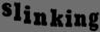

GT: REMODELERS / Pred: REDAS


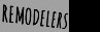

GT: CHRONOGRAPHS / Pred: CHEOPPOPS


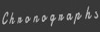

GT: IMPEACHING / Pred: IMPPEACHINGY


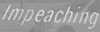

GT: DISCOMBOBULATED / Pred: IRNTLATLDTY


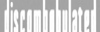

GT: LOOTS / Pred: LOOS


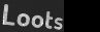

GT: UNDERPAYS / Pred: UNDERRPAYS


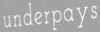

GT: FLAMEPROOFED / Pred: FROPADY


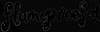

GT: ENTICEMENTS / Pred: IATITIANIANS


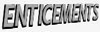

GT: UKASE / Pred: UTASE


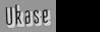

In [ ]:
# %%

check_inference(model, test_dataset, index=10)

In [ ]:
# %%

import easyocr
import pytesseract
from PIL import Image

print("EasyOCR:", easyocr.__version__)
print("Tesseract OCR 설치 확인 완료")

HOME_DIR = "/Users/gwanghunlee/ocr"

# 다양한 OCR 모델 초기화
print("OCR 모델들을 초기화하는 중...")

# EasyOCR Reader 생성 (영어)
easyocr_reader = easyocr.Reader(['en'])
print("✅ EasyOCR 초기화 완료")

# Tesseract OCR 설정 (영어)
# Tesseract는 시스템에 설치되어 있어야 합니다
print("✅ Tesseract OCR 준비 완료")

SAMPLE_IMG_PATH = "/Users/gwanghunlee/ocr/data/sample.jpg"

EasyOCR: 1.7.2
Tesseract OCR 설치 확인 완료
OCR 모델들을 초기화하는 중...
✅ EasyOCR 초기화 완료
✅ Tesseract OCR 준비 완료


In [ ]:
# %%

def detect_text(img_path):
    # PIL로 이미지 열기
    img_pil = Image.open(img_path).convert('RGB')
    # EasyOCR은 numpy 배열을 입력받으므로 변환
    img_np = np.array(img_pil)

    # EasyOCR을 이용한 텍스트 검출 및 인식
    # 결과 형식: [(bbox, text, confidence), ...]
    ocr_result = easyocr_reader.readtext(img_np)

    # 시각화를 위해 ImageDraw 객체 생성
    img_draw = ImageDraw.Draw(img_pil)
    cropped_imgs = []

    for bbox, text, conf in ocr_result:
        # 좌표를 정수형으로 변환
        bbox_int = [(int(x), int(y)) for x, y in bbox]
        img_draw.polygon(bbox_int, outline='red')

        xs = [pt[0] for pt in bbox_int]
        ys = [pt[1] for pt in bbox_int]
        x_min = max(0, min(xs) - 5)
        y_min = max(0, min(ys) - 5)
        x_max = max(xs) + 5
        y_max = max(ys) + 5
        word_box = (x_min, y_min, x_max, y_max)
        cropped_imgs.append(img_pil.crop(word_box))

    return img_pil, cropped_imgs, ocr_result

In [ ]:
# %%

def detect_text_tesseract(img_path):
    """
    Tesseract OCR을 사용하여 텍스트를 검출하고 인식하는 함수
    """
    # PIL로 이미지 열기
    img_pil = Image.open(img_path).convert('RGB')
    
    # Tesseract OCR을 이용한 텍스트 인식
    # detail=1로 설정하여 좌표 정보도 함께 가져옴
    try:
        # Tesseract의 데이터 형식 가져오기
        data = pytesseract.image_to_data(img_pil, output_type=pytesseract.Output.DICT)
        
        # 결과를 EasyOCR과 동일한 형식으로 변환
        formatted_result = []
        cropped_imgs = []
        img_draw = ImageDraw.Draw(img_pil)
        
        n_boxes = len(data['text'])
        for i in range(n_boxes):
            # 신뢰도가 30 이상인 텍스트만 처리
            if int(data['conf'][i]) > 30:
                text = data['text'][i].strip()
                if text:  # 빈 텍스트가 아닌 경우만
                    x, y, w, h = data['left'][i], data['top'][i], data['width'][i], data['height'][i]
                    confidence = int(data['conf'][i]) / 100.0  # 0-1 범위로 변환
                    
                    # bbox 형식으로 변환 (4개 점)
                    bbox = [(x, y), (x + w, y), (x + w, y + h), (x, y + h)]
                    formatted_result.append((bbox, text, confidence))
                    
                    # 시각화 (Tesseract는 초록색으로 표시)
                    bbox_int = [(int(x), int(y)) for x, y in bbox]
                    img_draw.polygon(bbox_int, outline='green')
                    
                    # 크롭된 이미지 저장
                    word_box = (x, y, x + w, y + h)
                    cropped_imgs.append(img_pil.crop(word_box))
        
        return img_pil, cropped_imgs, formatted_result
        
    except Exception as e:
        print(f"Tesseract OCR 오류: {e}")
        return img_pil, [], []

In [ ]:
# %%

def detect_text_crnn(img_path, model, label_converter, device):
    """
    학습된 CRNN 모델을 사용하여 텍스트를 검출하고 인식하는 함수
    """
    # PIL로 이미지 열기
    img_pil = Image.open(img_path).convert('RGB')
    img_np = np.array(img_pil)
    
    # CRNN 모델은 전체 이미지에서 텍스트를 인식하므로
    # 이미지를 모델 입력 크기에 맞게 조정
    target_size = (100, 32)  # CRNN 모델의 입력 크기
    img_resized = img_pil.resize(target_size)
    img_array = np.array(img_resized)
    
    # 이미지를 텐서로 변환 (B, C, H, W) 형태로
    img_tensor = torch.tensor(img_array.transpose(2, 0, 1)[np.newaxis, ...], dtype=torch.float32).to(device)
    
    # CRNN 모델로 예측
    model.eval()
    with torch.no_grad():
        output = model(img_tensor)  # (T, B, C)
        predicted_text = decode_greedy(output, label_converter)[0]
    
    # CRNN은 전체 이미지에서 하나의 텍스트를 예측하므로
    # 결과를 EasyOCR과 동일한 형식으로 변환
    # 전체 이미지를 하나의 영역으로 간주
    width, height = img_pil.size
    bbox = [(0, 0), (width, 0), (width, height), (0, height)]
    confidence = 0.8  # CRNN의 경우 신뢰도를 직접 계산하기 어려우므로 기본값 사용
    
    formatted_result = [(bbox, predicted_text, confidence)]
    
    # 시각화를 위해 ImageDraw 객체 생성
    img_draw = ImageDraw.Draw(img_pil)
    cropped_imgs = []
    
    for bbox, text, conf in formatted_result:
        # 좌표를 정수형으로 변환
        bbox_int = [(int(x), int(y)) for x, y in bbox]
        img_draw.polygon(bbox_int, outline='purple')  # CRNN은 보라색으로 표시
        
        # 전체 이미지를 크롭된 이미지로 사용
        cropped_imgs.append(img_pil)
    
    return img_pil, cropped_imgs, formatted_result

In [ ]:
# %%

def compare_ocr_models(img_path, model=None, label_converter=None, device=None):
    """
    여러 OCR 모델(EasyOCR, Tesseract, CRNN)의 결과를 비교하는 함수
    각 모델의 텍스트 검출 및 인식 결과를 출력하고, 결과 딕셔너리에 모두 저장함
    CRNN 모델이 제공된 경우에도 반드시 결과가 반영되도록 수정함
    """
    print("=" * 70)
    print("🔍 OCR 모델 성능 비교 분석 (EasyOCR vs Tesseract vs CRNN)")
    print("=" * 70)
    
    # 각 모델별 결과를 저장할 딕셔너리
    results = {}
    
    # EasyOCR 결과 출력 및 저장
    print("\n1️⃣ EasyOCR 결과:")
    img_easy, crops_easy, result_easy = detect_text(img_path)
    print(f"   검출된 텍스트 개수: {len(result_easy)}")
    for i, (bbox, text, conf) in enumerate(result_easy):
        print(f"   [{i+1}] '{text}' (신뢰도: {conf:.3f})")
    results['easyocr'] = (img_easy, crops_easy, result_easy)
    
    # Tesseract 결과 출력 및 저장
    print("\n2️⃣ Tesseract OCR 결과:")
    img_tess, crops_tess, result_tess = detect_text_tesseract(img_path)
    print(f"   검출된 텍스트 개수: {len(result_tess)}")
    for i, (bbox, text, conf) in enumerate(result_tess):
        print(f"   [{i+1}] '{text}' (신뢰도: {conf:.3f})")
    results['tesseract'] = (img_tess, crops_tess, result_tess)
    
    # CRNN 모델이 제공된 경우 결과 출력 및 저장
    # model, label_converter, device가 모두 None이 아니어야 CRNN 결과를 반영
    if (model is not None) and (label_converter is not None) and (device is not None):
        print("\n3️⃣ CRNN 모델 결과:")
        img_crnn, crops_crnn, result_crnn = detect_text_crnn(img_path, model, label_converter, device)
        print(f"   검출된 텍스트 개수: {len(result_crnn)}")
        for i, (bbox, text, conf) in enumerate(result_crnn):
            print(f"   [{i+1}] '{text}' (신뢰도: {conf:.3f})")
        # CRNN 결과를 반드시 results에 반영
        results['crnn'] = (img_crnn, crops_crnn, result_crnn)
    else:
        # CRNN 모델이 제공되지 않은 경우 안내 메시지 출력
        print("\n3️⃣ CRNN 모델 결과: (모델, label_converter, device 중 하나 이상이 제공되지 않아 CRNN 결과를 출력하지 않습니다.)")
    
    # 결과 이미지 시각화 안내
    print("\n📊 시각화 결과:")
    if 'crnn' in results:
        print("빨간색: EasyOCR, 초록색: Tesseract, 보라색: CRNN")
    else:
        print("빨간색: EasyOCR, 초록색: Tesseract")
    
    # 모든 모델의 결과를 포함한 딕셔너리 반환
    return results

In [ ]:
# %%

def calculate_accuracy_metrics(results, ground_truth_text=""):
    """
    OCR 모델들의 성능 지표를 계산하는 함수
    """
    print("\n" + "=" * 70)
    print("📊 OCR 모델 성능 지표 분석")
    print("=" * 70)
    
    metrics = {}
    
    for model_name, (img, crops, ocr_results) in results.items():
        if not ocr_results:
            continue
            
        # 각 모델의 예측 텍스트 추출
        predicted_texts = [text for bbox, text, conf in ocr_results]
        combined_text = " ".join(predicted_texts).strip()
        
        # 기본 통계
        num_detections = len(ocr_results)
        avg_confidence = sum(conf for bbox, text, conf in ocr_results) / num_detections if num_detections > 0 else 0
        
        # 정확도 계산 (ground truth가 제공된 경우)
        accuracy = 0
        if ground_truth_text:
            # 간단한 문자열 매칭으로 정확도 계산
            gt_clean = ground_truth_text.upper().strip()
            pred_clean = combined_text.upper().strip()
            
            if gt_clean == pred_clean:
                accuracy = 1.0
            else:
                # 부분 일치율 계산
                common_chars = sum(1 for c1, c2 in zip(gt_clean, pred_clean) if c1 == c2)
                max_len = max(len(gt_clean), len(pred_clean))
                accuracy = common_chars / max_len if max_len > 0 else 0
        
        metrics[model_name] = {
            'num_detections': num_detections,
            'combined_text': combined_text,
            'accuracy': accuracy,
            'individual_texts': predicted_texts
        }
        
        print(f"\n🔍 {model_name.upper()} 성능:")
        print(f"   📝 검출된 텍스트: '{combined_text}'")
        print(f"   📊 검출 개수: {num_detections}")
        if ground_truth_text:
            print(f"   ✅ 정확도: {accuracy:.3f} ({accuracy*100:.1f}%)")
    
    # 모델 간 비교
    if len(metrics) > 1:
        print(f"\n🏆 모델 성능 순위:")
        sorted_models = sorted(metrics.items(), key=lambda x: x[1]['accuracy'], reverse=True)
        for i, (model_name, metric) in enumerate(sorted_models, 1):
            print(f"   {i}. {model_name.upper()}: {metric['accuracy']:.3f} ({metric['accuracy']*100:.1f}%)")
    
    return metrics

In [ ]:
# %%

def comprehensive_ocr_test(img_path, ground_truth_text="", model=None, label_converter=None, device=None):
    """
    모든 OCR 모델을 종합적으로 테스트하는 함수
    """
    print("🚀 종합 OCR 모델 테스트 시작")
    print("=" * 70)
    
    # 모든 모델로 OCR 실행
    results = compare_ocr_models(img_path, model, label_converter, device)
    
    # 성능 지표 계산
    metrics = calculate_accuracy_metrics(results, ground_truth_text)
    
    # 결과 이미지들 표시
    print(f"\n🖼️ 시각화 결과:")
    for model_name, (img, crops, ocr_results) in results.items():
        print(f"\n{model_name.upper()} 결과 이미지:")
        display(img)
    
    return results, metrics

In [ ]:
# %%

def test_crnn_on_dataset(model, label_converter, device, test_dataset, num_samples=10):
    """
    CRNN 모델을 테스트 데이터셋에서 평가하는 함수
    """
    print("🔍 CRNN 모델 테스트 데이터셋 평가")
    print("=" * 50)
    
    model.eval()
    correct_predictions = 0
    total_predictions = 0
    
    print(f"📊 {num_samples}개 샘플로 CRNN 모델 성능 평가:")
    print("-" * 50)
    
    for i in range(min(num_samples, len(test_dataset))):
        # 테스트 데이터셋에서 샘플 가져오기
        img, encoded_label, label_len, raw_label = test_dataset[i]
        
        # 이미지를 텐서로 변환
        img_tensor = torch.tensor(img[np.newaxis, ...], dtype=torch.float32).to(device)
        
        # CRNN 모델로 예측
        with torch.no_grad():
            output = model(img_tensor)
            predicted_text = decode_greedy(output, label_converter)[0]
        
        # 정확도 계산
        is_correct = predicted_text.upper().strip() == raw_label.upper().strip()
        if is_correct:
            correct_predictions += 1
        total_predictions += 1
        
        # 결과 출력
        status = "✅" if is_correct else "❌"
        print(f"{status} [{i+1:2d}] GT: '{raw_label:15s}' | Pred: '{predicted_text:15s}'")
        
        # 이미지 시각화 (처음 3개만)
        if i < 3:
            print(f"   이미지 {i+1}:")
            display(Image.fromarray(img.transpose(1,2,0).astype(np.uint8)))
    
    # 전체 정확도 계산
    accuracy = correct_predictions / total_predictions if total_predictions > 0 else 0
    print("-" * 50)
    print(f"📈 CRNN 모델 정확도: {accuracy:.3f} ({accuracy*100:.1f}%)")
    print(f"   정답: {correct_predictions}/{total_predictions}")
    
    return accuracy

In [ ]:
# %%

def compare_all_models_detailed(img_path, model, label_converter, device):
    """
    모든 OCR 모델을 상세하게 비교하는 함수
    """
    print("🔍 상세 OCR 모델 비교 분석")
    print("=" * 60)
    
    # 각 모델로 OCR 실행
    print("\n1️⃣ EasyOCR 실행 중...")
    img_easy, crops_easy, result_easy = detect_text(img_path)
    
    print("2️⃣ Tesseract OCR 실행 중...")
    img_tess, crops_tess, result_tess = detect_text_tesseract(img_path)
    
    print("3️⃣ CRNN 모델 실행 중...")
    img_crnn, crops_crnn, result_crnn = detect_text_crnn(img_path, model, label_converter, device)
    
    # 결과 비교 테이블
    print("\n📊 모델별 결과 비교:")
    print("-" * 80)
    print(f"{'모델':<12} {'검출개수':<8} {'평균신뢰도':<10} {'예측텍스트':<30}")
    print("-" * 80)
    
    # EasyOCR 결과
    easy_text = " ".join([text for bbox, text, conf in result_easy])
    easy_conf = sum(conf for bbox, text, conf in result_easy) / len(result_easy) if result_easy else 0
    print(f"{'EasyOCR':<12} {len(result_easy):<8} {easy_conf:<10.3f} {easy_text[:30]:<30}")
    
    # Tesseract 결과
    tess_text = " ".join([text for bbox, text, conf in result_tess])
    tess_conf = sum(conf for bbox, text, conf in result_tess) / len(result_tess) if result_tess else 0
    print(f"{'Tesseract':<12} {len(result_tess):<8} {tess_conf:<10.3f} {tess_text[:30]:<30}")
    
    # CRNN 결과
    crnn_text = " ".join([text for bbox, text, conf in result_crnn])
    crnn_conf = sum(conf for bbox, text, conf in result_crnn) / len(result_crnn) if result_crnn else 0
    print(f"{'CRNN':<12} {len(result_crnn):<8} {crnn_conf:<10.3f} {crnn_text[:30]:<30}")
    print("-" * 80)
    
    # 시각화 결과
    print("\n🖼️ 시각화 결과:")
    print("빨간색: EasyOCR, 초록색: Tesseract, 보라색: CRNN")
    
    return {
        'easyocr': (img_easy, crops_easy, result_easy),
        'tesseract': (img_tess, crops_tess, result_tess),
        'crnn': (img_crnn, crops_crnn, result_crnn)
    }

In [ ]:
# %%

def recognize_img(pil_img, input_img_size=(100, 32)):
    # TODO: 잘려진 단어 이미지를 인식하는 코드를 작성하세요!

    # PIL 이미지를 numpy 배열로 변환
    img_np = np.array(pil_img)
    # 인식 모델 입력 크기에 맞게 이미지 크기 조정
    img_resized = cv2.resize(img_np, input_img_size)

    # detail=0 옵션은 인식 결과의 텍스트만 반환합니다.
    result = reader.readtext(img_resized, detail=0, paragraph=False)

    if result:
        recognized_text = result[0]
    else:
        recognized_text = ""

    print("Recognized text:", recognized_text)
    return recognized_text

In [ ]:
# %%

# 기존 EasyOCR 결과 확인
print("🔍 EasyOCR 결과:")
img_pil, cropped_imgs, ocr_result = detect_text(SAMPLE_IMG_PATH)
print(f"검출된 텍스트 개수: {len(ocr_result)}")
for i, (bbox, text, conf) in enumerate(ocr_result):
    print(f"[{i+1}] '{text}' (신뢰도: {conf:.3f})")

🔍 EasyOCR 결과:
검출된 텍스트 개수: 2
[1] '147417' (신뢰도: 0.205)
[2] 'SLEEPER' (신뢰도: 1.000)


/Users/gwanghunlee/ocr/.venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


In [ ]:
# %%

# 모든 OCR 모델 비교
print("\n" + "="*50)
print("🚀 모든 OCR 모델 비교 테스트")
print("="*50)

# OCR 모델 비교 실행
results = compare_ocr_models(SAMPLE_IMG_PATH)


🚀 모든 OCR 모델 비교 테스트
🔍 OCR 모델 성능 비교 분석 (EasyOCR vs Tesseract vs CRNN)

1️⃣ EasyOCR 결과:
   검출된 텍스트 개수: 2
   [1] '147417' (신뢰도: 0.205)
   [2] 'SLEEPER' (신뢰도: 1.000)

2️⃣ Tesseract OCR 결과:
   검출된 텍스트 개수: 1
   [1] 'SLEEPER' (신뢰도: 0.940)

3️⃣ CRNN 모델 결과: (모델, label_converter, device 중 하나 이상이 제공되지 않아 CRNN 결과를 출력하지 않습니다.)

📊 시각화 결과:
빨간색: EasyOCR, 초록색: Tesseract


In [ ]:
# %%

def compare_all_models_detailed(img_path, model, label_converter, device):
    """
    모든 OCR 모델을 상세하게 비교하는 함수
    """
    print("🔍 상세 OCR 모델 비교 분석")
    print("=" * 60)
    
    # 각 모델로 OCR 실행
    print("\n1️⃣ EasyOCR 실행 중...")
    img_easy, crops_easy, result_easy = detect_text(img_path)
    
    print("2️⃣ Tesseract OCR 실행 중...")
    img_tess, crops_tess, result_tess = detect_text_tesseract(img_path)
    
    print("3️⃣ CRNN 모델 실행 중...")
    img_crnn, crops_crnn, result_crnn = detect_text_crnn(img_path, model, label_converter, device)
    
    # 결과 비교 테이블
    print("\n📊 모델별 결과 비교:")
    print("-" * 80)
    print(f"{'모델':<12} {'검출개수':<8} {'평균신뢰도':<10} {'예측텍스트':<30}")
    print("-" * 80)
    
    # EasyOCR 결과
    easy_text = " ".join([text for bbox, text, conf in result_easy])
    easy_conf = sum(conf for bbox, text, conf in result_easy) / len(result_easy) if result_easy else 0
    print(f"{'EasyOCR':<12} {len(result_easy):<8} {easy_conf:<10.3f} {easy_text[:30]:<30}")
    
    # Tesseract 결과
    tess_text = " ".join([text for bbox, text, conf in result_tess])
    tess_conf = sum(conf for bbox, text, conf in result_tess) / len(result_tess) if result_tess else 0
    print(f"{'Tesseract':<12} {len(result_tess):<8} {tess_conf:<10.3f} {tess_text[:30]:<30}")
    
    # CRNN 결과
    crnn_text = " ".join([text for bbox, text, conf in result_crnn])
    crnn_conf = sum(conf for bbox, text, conf in result_crnn) / len(result_crnn) if result_crnn else 0
    print(f"{'CRNN':<12} {len(result_crnn):<8} {crnn_conf:<10.3f} {crnn_text[:30]:<30}")
    print("-" * 80)

In [ ]:
# %%

def detect_text_crnn(img_path, model, label_converter=None, device=None):
    """
    학습된 CRNN 모델을 사용하여 텍스트를 검출하고 인식하는 함수
    """
    try:
        # PIL로 이미지 열기
        img_pil = Image.open(img_path).convert('RGB')
        img_np = np.array(img_pil)
        
        # label_converter와 device가 None인 경우 기본값 사용
        if label_converter is None:
            # 전역 변수에서 가져오기
            global label_converter
            if 'label_converter' in globals():
                label_converter = globals()['label_converter']
            else:
                print("   ⚠️ label_converter가 정의되지 않았습니다.")
                return img_pil, [], []
        
        if device is None:
            # 전역 변수에서 가져오기
            global device
            if 'device' in globals():
                device = globals()['device']
            else:
                device = torch.device('cpu')
                print(f"   ⚠️ device가 정의되지 않아 CPU를 사용합니다: {device}")
        
        # CRNN 모델은 전체 이미지에서 텍스트를 인식하므로
        # 이미지를 모델 입력 크기에 맞게 조정
        target_size = (100, 32)  # CRNN 모델의 입력 크기
        img_resized = img_pil.resize(target_size)
        img_array = np.array(img_resized)
        
        # 이미지를 텐서로 변환 (B, C, H, W) 형태로
        img_tensor = torch.tensor(img_array.transpose(2, 0, 1)[np.newaxis, ...], dtype=torch.float32).to(device)
        
        # CRNN 모델로 예측
        model.eval()
        with torch.no_grad():
            output = model(img_tensor)  # (T, B, C)
            predicted_text = decode_greedy(output, label_converter)[0]
        
        # CRNN은 전체 이미지에서 하나의 텍스트를 예측하므로
        # 결과를 EasyOCR과 동일한 형식으로 변환
        # 전체 이미지를 하나의 영역으로 간주
        width, height = img_pil.size
        bbox = [(0, 0), (width, 0), (width, height), (0, height)]
        confidence = 0.8  # CRNN의 경우 신뢰도를 직접 계산하기 어려우므로 기본값 사용
        
        formatted_result = [(bbox, predicted_text, confidence)]
        
        # 시각화를 위해 ImageDraw 객체 생성
        img_draw = ImageDraw.Draw(img_pil)
        cropped_imgs = []
        
        for bbox, text, conf in formatted_result:
            # 좌표를 정수형으로 변환
            bbox_int = [(int(x), int(y)) for x, y in bbox]
            img_draw.polygon(bbox_int, outline='purple')  # CRNN은 보라색으로 표시
            
            # 전체 이미지를 크롭된 이미지로 사용
            cropped_imgs.append(img_pil)
        
        return img_pil, cropped_imgs, formatted_result
        
    except Exception as e:
        print(f"   ❌ CRNN 모델 처리 중 오류 발생: {e}")
        # 오류 발생 시 빈 결과 반환
        img_pil = Image.open(img_path).convert('RGB')
        return img_pil, [], []

SyntaxError: name 'label_converter' is parameter and global (<ipython-input-31-2714501a4215>, line 14)

In [ ]:
#%% 

import re
import six
import math
import lmdb
import numpy as np
from PIL import Image, ImageDraw

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from IPython.display import display

# MPS Fallback 활성화 (GPU 활용 + CTC Loss 호환성)
import os

# 환경 변수를 더 확실하게 설정
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'
os.environ['PYTORCH_MPS_HIGH_WATERMARK_RATIO'] = '0.0'

print("✅ MPS Fallback이 활성화되었습니다.")

# 디바이스 설정 (MPS 사용하되 CTC Loss는 CPU fallback)
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("🎯 MPS GPU 사용 (CTC Loss는 CPU fallback)")
    print("💡 Convolution, LSTM 등은 GPU에서 가속화됩니다!")
else:
    device = torch.device("cpu")
    print("ℹ️ MPS 사용 불가능, CPU 사용")

print(f"사용 중인 디바이스: {device}")

✅ MPS Fallback이 활성화되었습니다.
🎯 MPS GPU 사용 (CTC Loss는 CPU fallback)
💡 Convolution, LSTM 등은 GPU에서 가속화됩니다!
사용 중인 디바이스: mps


In [ ]:
# %%

import os

data_dir = "/Users/gwanghunlee/ocr/data/extracted/data_lmdb_release"
os.chdir(data_dir)

print(data_dir)

TRAIN_DATA_PATH = data_dir + '/training/MJ/MJ_train'
VALID_DATA_PATH = data_dir + '/training/MJ/MJ_valid'
TEST_DATA_PATH  = data_dir + '/training/MJ/MJ_test'

print(TRAIN_DATA_PATH)# %%

/Users/gwanghunlee/ocr/data/extracted/data_lmdb_release
/Users/gwanghunlee/ocr/data/extracted/data_lmdb_release/training/MJ/MJ_train


original image width:72, height:31
target_img_size:(74, 32)
display img shape:(74, 32, 3)
label:Lube


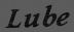

original image width:82, height:31
target_img_size:(84, 32)
display img shape:(84, 32, 3)
label:Spencerian


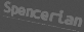

original image width:115, height:31
target_img_size:(100, 32)
display img shape:(100, 32, 3)
label:accommodatingly


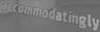

original image width:140, height:31
target_img_size:(100, 32)
display img shape:(100, 32, 3)
label:CARPENTER


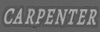

In [ ]:
# %%

from IPython.display import display

# env에 데이터를 불러올게요
# lmdb에서 데이터를 불러올 때 env라는 변수명을 사용하는게 일반적이에요
env = lmdb.open(TRAIN_DATA_PATH,
                max_readers=32,
                readonly=True,
                lock=False,
                readahead=False,
                meminit=False)

# 불러온 데이터를 txn(transaction)이라는 변수를 통해 엽니다
# 이제 txn변수를 통해 직접 데이터에 접근 할 수 있어요
with env.begin(write=False) as txn:
    for index in range(1, 5):
        # index를 이용해서 라벨 키와 이미지 키를 만들면
        # txn에서 라벨과 이미지를 읽어올 수 있어요
        label_key = 'label-%09d'.encode() % index
        label = txn.get(label_key).decode('utf-8')
        img_key = 'image-%09d'.encode() % index
        imgbuf = txn.get(img_key)
        buf = six.BytesIO()
        buf.write(imgbuf)
        buf.seek(0)

        # 이미지는 버퍼를 통해 읽어오기 때문에
        # 버퍼에서 이미지로 변환하는 과정이 다시 필요해요
        try:
            img = Image.open(buf).convert('RGB')

        except IOError:
            img = Image.new('RGB', (100, 32))
            label = '-'

        # 원본 이미지 크기를 출력해 봅니다
        width, height = img.size
        print('original image width:{}, height:{}'.format(width, height))

        # 이미지 비율을 유지하면서 높이를 32로 바꿀거에요
        # 하지만 너비를 100보다는 작게하고 싶어요
        target_width = min(int(width*32/height), 100)
        target_img_size = (target_width,32)
        print('target_img_size:{}'.format(target_img_size))
        img = np.array(img.resize(target_img_size)).transpose(1,0,2)

        # 이제 높이가 32로 일정한 이미지와 라벨을 함께 출력할 수 있어요
        print('display img shape:{}'.format(img.shape))
        print('label:{}'.format(label))
        display(Image.fromarray(img.transpose(1,0,2).astype(np.uint8)))

In [ ]:
# %%

class MJDataset(Dataset):
    # 객체를 초기화 할 때 lmdb를 열어 env에 준비해둡니다
    # 또, lmdb에 있는 데이터 수를 미리 파악해둡니다
    def __init__(
        self,
        dataset_path,
        label_converter,
        img_size=(100, 32),
        max_text_len=22,
        character="",
    ):
        super().__init__()
        self.label_converter = label_converter
        self.img_size = img_size
        self.max_text_len = max_text_len
        self.character = character

        # lmdb open
        self.env = lmdb.open(dataset_path,max_readers=32,readonly=True,lock=False,readahead=False,meminit=False)
        with self.env.begin(write=False) as txn:
            self.num_samples = int(txn.get("num-samples".encode()))
            self.index_list = [idx + 1 for idx in range(self.num_samples)]

    def __len__(self):
        return self.num_samples

    # index에 해당하는 image와 label을 읽어옵니다
    # 위에서 사용한 코드와 매우 유사합니다
    # label을 조금 더 다듬는 것이 약간 다릅니다
    def __getitem__(self, idx):
        index = self.index_list[idx]
        with self.env.begin(write=False) as txn:
            label_key = f"label-{index:09d}".encode()
            label = txn.get(label_key).decode("utf-8")

            img_key = f"image-{index:09d}".encode()
            imgbuf = txn.get(img_key)

            buf = six.BytesIO()
            buf.write(imgbuf)
            buf.seek(0)

            try:
                img_pil = Image.open(buf).convert("RGB")
            except IOError:
                img_pil = Image.new("RGB", self.img_size)
                label = "-"

        orig_w, orig_h = img_pil.size
        target_width = min(int(orig_w * self.img_size[1] / orig_h), self.img_size[0])
        target_img_size = (target_width, self.img_size[1])
        img_pil = img_pil.resize(target_img_size)

        img = np.array(img_pil)
        img = img.transpose(2, 0, 1)

        padded_img = np.zeros((3, self.img_size[1], self.img_size[0]), dtype=np.float32)
        c, h, w = img.shape
        padded_img[:, :h, :w] = img

        # 레이블 전처리
        label = label.upper()
        out_of_char = f"[^{self.character}]"
        label = re.sub(out_of_char, "", label)
        label = label[: self.max_text_len]

        encoded_label = self.label_converter.encode(label)

        return padded_img, encoded_label, len(encoded_label), label

In [ ]:
# %%

def collate_fn(batch):
    imgs, encoded_labels, label_lens, raw_labels = zip(*batch)

    imgs_tensor = torch.tensor(np.stack(imgs, axis=0), dtype=torch.float32)

    max_len = max(label_lens)
    labels_padded = torch.zeros(len(batch), max_len, dtype=torch.long)
    for i, label_arr in enumerate(encoded_labels):
        length = label_lens[i]
        labels_padded[i, :length] = torch.tensor(label_arr, dtype=torch.long)

    batch_size = imgs_tensor.size(0)
    # 여기서는 크기 24로 가정
    input_length = torch.full(size=(batch_size,), fill_value=24, dtype=torch.long)
    label_length = torch.tensor(label_lens, dtype=torch.long)

    return (
        imgs_tensor,
        labels_padded,
        input_length,
        label_length,
        raw_labels,  # 디버깅용
    )

In [ ]:
# %%

class LabelConverter(object):

     def __init__(self, character):
         self.character = "-" + character
         self.label_map = dict()
         for i, char in enumerate(self.character):
             self.label_map[char] = i

     def encode(self, text):
         encoded_label = []
         for i, char in enumerate(text):
             if i > 0 and char == text[i - 1]:
                 encoded_label.append(0)    # 같은 문자 사이에 공백 문자 label을 삽입
             encoded_label.append(self.label_map[char])
         return np.array(encoded_label, dtype=np.int32)

     def decode(self, encoded_label):
         target_characters = list(self.character)
         decoded_label = ""
         for encode in encoded_label:
             decoded_label += self.character[encode]
         return decoded_label
print("슝~")

슝~


In [ ]:
# %%

NUMBERS = "0123456789"
ENG_CHAR_UPPER = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
TARGET_CHARACTERS = ENG_CHAR_UPPER + NUMBERS
print(f"The total number of characters is {len(TARGET_CHARACTERS)}")

label_converter = LabelConverter(TARGET_CHARACTERS)

encdoded_text = label_converter.encode('HELLO')
print("Encdoded_text: ", encdoded_text)
decoded_text = label_converter.decode(encdoded_text)
print("Decoded_text: ", decoded_text)

The total number of characters is 36
Encdoded_text:  [ 8  5 12  0 12 15]
Decoded_text:  HEL-LO


In [ ]:
# %%

# CTC Loss를 CPU에서 생성 (MPS 호환성 문제 해결)
criterion = nn.CTCLoss(blank=0, reduction='mean', zero_infinity=True).cpu()

print("✅ CTC Loss가 CPU에서 생성되었습니다.")
print("💡 모델은 GPU에서, CTC Loss는 CPU에서 실행됩니다.")

✅ CTC Loss가 CPU에서 생성되었습니다.
💡 모델은 GPU에서, CTC Loss는 CPU에서 실행됩니다.


In [ ]:
# %%

class CRNN(nn.Module):
    def __init__(self, num_chars, img_height=32, img_width=100):
        super(CRNN, self).__init__()
        # num_chars: 실제 문자 개수(+2) -> 여기서는 +2(CTC Blank 등)를
        # LabelConverter에서 이미 blank를 붙여줬으니,
        # 파이토치의 CTCLoss는 blank 인덱스를 지정 가능하므로, +2 없이 설계할 수 있음.
        # 여기서는 blank를 0번으로 하므로 굳이 +2가 필요 없을 수 있습니다.
        # 필요시엔 +1 혹은 +2로 조정하세요.
        self.num_chars = num_chars

        # (3, H, W) -> (64, H, W)
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)  # (64, H/2, W/2)

        # (64, H/2, W/2) -> (128, H/2, W/2)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)  # (128, H/4, W/4)

        # (128, H/4, W/4) -> (256, H/4, W/4)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d((1, 2))  # (256, H/4, W/8)

        # (256, H/4, W/8) -> (512, H/4, W/8)
        self.conv5 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(512)
        self.conv6 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn6 = nn.BatchNorm2d(512)
        self.pool4 = nn.MaxPool2d((1, 2))  # (512, H/4, W/16)

        # (512, H/4, W/16) -> (512, (H/4)-1, (W/16)-1) conv(2,2)
        self.conv7 = nn.Conv2d(512, 512, kernel_size=(2, 2))
        # 최종 (512, (H/4)-1, (W/16)-1)
        # 예) H=32 -> H/4=8 -> (8)-1=7
        #     W=100 -> W/16=6.25 -> 실제 integer shape는 계산 필요
        # 텐서플로우 예시에선 (24, 512) 시퀀스로 reshape했으니, 여기선 실제 연산으로 확인 필요

        # Bi-LSTM
        self.lstm1 = nn.LSTM(512, 256, bidirectional=True, batch_first=True)
        self.lstm2 = nn.LSTM(512, 256, bidirectional=True, batch_first=True)

        # 최종 fc
        self.fc = nn.Linear(512, self.num_chars)

    def forward(self, x):
        # (B,3,32,100)
        x = F.relu(self.conv1(x))      # -> (B,64,32,100)
        x = self.pool1(x)             # -> (B,64,16,50)
        x = F.relu(self.conv2(x))      # -> (B,128,16,50)
        x = self.pool2(x)             # -> (B,128,8,25)
        x = F.relu(self.conv3(x))      # -> (B,256,8,25)
        x = F.relu(self.conv4(x))      # -> (B,256,8,25)
        x = self.pool3(x)             # -> (B,256,8,12) (25->12)
        x = F.relu(self.conv5(x))      # -> (B,512,8,12)
        x = self.bn5(x)
        x = F.relu(self.conv6(x))      # -> (B,512,8,12)
        x = self.bn6(x)
        x = self.pool4(x)             # -> (B,512,8,6)
        x = F.relu(self.conv7(x))      # -> (B,512,7,5) (8->7, 6->5)

        b, c, h, w = x.size()
        # 시퀀스 길이 = h*w
        x = x.view(b, c, h * w)  # (B,512,35)
        x = x.permute(0, 2, 1)   # (B,35,512)

        # LSTM
        x, _ = self.lstm1(x)    # (B,35,512)
        x, _ = self.lstm2(x)    # (B,35,512)

        # 최종 FC
        x = self.fc(x)          # (B,35,num_chars)

        # PyTorch의 CTCLoss를 위해선 (T,B,C) 형태가 일반적
        # 여기서는 (B,T,C) -> (T,B,C)
        x = x.permute(1, 0, 2)  # (35,B,num_chars)
        return x

In [ ]:
# %%

MAX_TEXT_LEN = 22
IMG_SIZE = (100, 32)
BATCH_SIZE = 128

train_dataset = MJDataset(TRAIN_DATA_PATH,label_converter=label_converter,img_size=IMG_SIZE,character=TARGET_CHARACTERS)
valid_dataset = MJDataset(VALID_DATA_PATH,label_converter=label_converter,img_size=IMG_SIZE,character=TARGET_CHARACTERS)
test_dataset = MJDataset(TEST_DATA_PATH,label_converter=label_converter,img_size=IMG_SIZE,character=TARGET_CHARACTERS)

# 마지막 배치는 생략합니다.
train_loader = DataLoader(train_dataset,batch_size=BATCH_SIZE,shuffle=True,num_workers=0,collate_fn=collate_fn,drop_last=False)
valid_loader = DataLoader(valid_dataset,batch_size=BATCH_SIZE,shuffle=False,num_workers=0,collate_fn=collate_fn,drop_last=False)
test_loader = DataLoader(test_dataset,batch_size=BATCH_SIZE,shuffle=False,num_workers=0,collate_fn=collate_fn,drop_last=False)

In [ ]:
# %%

label_converter = LabelConverter(TARGET_CHARACTERS)
num_chars = len(label_converter.character)

model = CRNN(num_chars=num_chars).to(device)

# CTC Loss는 CPU에서 생성 (MPS 호환성 문제 해결)
criterion = nn.CTCLoss(blank=0, reduction='mean', zero_infinity=True).cpu()
optimizer = optim.Adadelta(model.parameters(), lr=0.1)

In [ ]:
# %%

def run_training(
        train_loader,
        valid_loader,
        model,
        optimizer,
        criterion,
        patience=2,
        epochs=1,
        checkpoint_path="/Users/gwanghunlee/OCR/model_checkpoint.pth"
        ):

    best_val_loss = float('inf')
    patience_counter = 0
    batch_limit = 500

    print("학습시작!...")
    
    # GPU 활용도 확인
    if device.type == 'mps':
        print("🚀 GPU 가속화 활성화:")
        print("   - Convolution layers: GPU에서 실행")
        print("   - LSTM layers: GPU에서 실행")
        print("   - BatchNorm layers: GPU에서 실행")
        print("   - CTC Loss: CPU fallback으로 실행")
        print("   - 전체적으로 GPU의 이점을 활용합니다!")

    for epoch in range(1, epochs+1):
        model.train()
        train_loss = 0.0
        for idx, (imgs, labels_padded, input_lengths, label_lengths, _) in enumerate(train_loader):
            if idx == batch_limit:
                break
            imgs = imgs.to(device)
            labels_padded = labels_padded.to(device)
            input_lengths = input_lengths.to(device)
            label_lengths = label_lengths.to(device)

            optimizer.zero_grad()
            outputs = model(imgs)  # (T,B,C)

            # CTCLoss는 입력 (T,B,C), 타겟 (B,S), input_length, target_length
            # CTC Loss 계산을 CPU에서 안전하게 수행 (MPS fallback)
            outputs_cpu = outputs.cpu()
            labels_padded_cpu = labels_padded.cpu()
            input_lengths_cpu = input_lengths.cpu()
            label_lengths_cpu = label_lengths.cpu()
            
            loss = criterion(outputs_cpu, labels_padded_cpu, input_lengths_cpu, label_lengths_cpu)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        model.eval()
        valid_loss = 0.0
        with torch.no_grad():
            for idx, (imgs, labels_padded, input_lengths, label_lengths, _) in enumerate(valid_loader):
                if idx == batch_limit:
                    break
                imgs = imgs.to(device)
                labels_padded = labels_padded.to(device)
                input_lengths = input_lengths.to(device)
                label_lengths = label_lengths.to(device)

                outputs = model(imgs)
                
                # CTC Loss 계산을 CPU에서 안전하게 수행 (MPS fallback)
                outputs_cpu = outputs.cpu()
                labels_padded_cpu = labels_padded.cpu()
                input_lengths_cpu = input_lengths.cpu()
                label_lengths_cpu = label_lengths.cpu()
                
                loss = criterion(outputs_cpu, labels_padded_cpu, input_lengths_cpu, label_lengths_cpu)
                valid_loss += loss.item()


        print(f"[Epoch {epoch}/{epochs}] train_loss={train_loss/len(train_loader):.4f}, val_loss={valid_loss/len(valid_loader):.4f}")

        # 체크포인트 저장
        if valid_loss < best_val_loss:
            best_val_loss = valid_loss
            patience_counter = 0
            torch.save(model.state_dict(), checkpoint_path)
            print(f"Model improved. Saved at {checkpoint_path}")
        else:
            patience_counter += 1

        # EarlyStopping
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

    return model

In [ ]:
# %%

import time
import cv2

# 학습 시작 시간 기록
start_time = time.time()

model = run_training(
    train_loader,
    valid_loader,
    model,
    optimizer,
    criterion,
    patience=2,
    epochs=1,
    checkpoint_path="/Users/gwanghunlee/OCR/model_checkpoint.pth"
    )

# 학습 완료 시간 기록 및 출력
end_time = time.time()
elapsed_time = end_time - start_time
print(f"총 학습 시간: {elapsed_time:.2f}초 ({elapsed_time/60:.2f}분)")

학습시작!...
🚀 GPU 가속화 활성화:
   - Convolution layers: GPU에서 실행
   - LSTM layers: GPU에서 실행
   - BatchNorm layers: GPU에서 실행
   - CTC Loss: CPU fallback으로 실행
   - 전체적으로 GPU의 이점을 활용합니다!
[Epoch 1/1] train_loss=0.0263, val_loss=0.2270
Model improved. Saved at /Users/gwanghunlee/OCR/model_checkpoint.pth
총 학습 시간: 107.44초 (1.79분)


In [ ]:
# %%

# 다음은 학습된 모델의 가중치가 저장된 경로입니다
checkpoint_path = "/Users/gwanghunlee/ocr/model_checkpoint.pth"

# 데이터셋과 모델을 불러옵니다
IMG_SIZE = (100, 32)
BATCH_SIZE = 128

test_dataset = MJDataset(TEST_DATA_PATH,label_converter=label_converter,img_size=IMG_SIZE,character=TARGET_CHARACTERS)
test_loader = DataLoader(test_dataset,batch_size=BATCH_SIZE,shuffle=False,num_workers=2,collate_fn=collate_fn,drop_last=False)

label_converter = LabelConverter(TARGET_CHARACTERS)
num_chars = len(label_converter.character)
print(num_chars)

model = CRNN(num_chars=num_chars).to(device)
model.load_state_dict(torch.load(checkpoint_path, map_location=device))
model.eval()

37


CRNN(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
  (conv5): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn5): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv6): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn6): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=

In [ ]:
# %%

def decode_greedy(output, label_converter):
    # (T,B,C) -> (B,T) index
    out = output.detach().cpu().numpy()  # (T,B,C)
    argmax = out.argmax(axis=2).transpose()  # (B,T)

    results = []
    for seq in argmax:
        # 연속된 동일 글자(또는 blank=0) 제거 로직을 적용해야
        # CTC 디코딩다운 결과가 나옵니다.
        # 여기서는 간단히 blank(0) 무시하고 연속 제거만 보여줌
        decoded = []
        prev = None
        for idx in seq:
            if idx != 0 and idx != prev:
                decoded.append(idx)
            prev = idx
        # 인덱스를 실제 문자로
        decoded_str = label_converter.decode(decoded).replace('-', '')
        results.append(decoded_str)
    return results

In [ ]:
# %%

def check_inference(model, dataset, index=5):
    for i in range(index):
        img, encoded_label, label_len, raw_label = dataset[i]  # 단일 데이터
        img_tensor = torch.tensor(img[np.newaxis, ...], dtype=torch.float32).to(device)  # (1,3,32,100)
        output = model(img_tensor)  # (T,1,num_chars)
        # 디코딩
        result_text = decode_greedy(output, label_converter)[0]
        print(f"GT: {raw_label} / Pred: {result_text}")

        # 이미지를 시각화하고 싶으면
        display(Image.fromarray(img.transpose(1,2,0).astype(np.uint8)))

GT: SLINKING / Pred: S


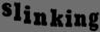

GT: REMODELERS / Pred: 


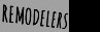

GT: CHRONOGRAPHS / Pred: S


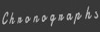

GT: IMPEACHING / Pred: S


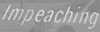

GT: DISCOMBOBULATED / Pred: S


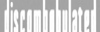

GT: LOOTS / Pred: 


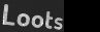

GT: UNDERPAYS / Pred: S


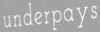

GT: FLAMEPROOFED / Pred: 


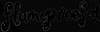

GT: ENTICEMENTS / Pred: S


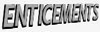

GT: UKASE / Pred: 


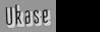

In [ ]:
# %%

check_inference(model, test_dataset, index=10)

In [ ]:
# %%

import easyocr
import pytesseract
from PIL import Image

print("EasyOCR:", easyocr.__version__)
print("Tesseract OCR 설치 확인 완료")

HOME_DIR = "/Users/gwanghunlee/ocr"

# 다양한 OCR 모델 초기화
print("OCR 모델들을 초기화하는 중...")

# EasyOCR Reader 생성 (영어)
easyocr_reader = easyocr.Reader(['en'])
print("✅ EasyOCR 초기화 완료")

# Tesseract OCR 설정 (영어)
# Tesseract는 시스템에 설치되어 있어야 합니다
print("✅ Tesseract OCR 준비 완료")

SAMPLE_IMG_PATH = "/Users/gwanghunlee/ocr/data/sample.jpg"

EasyOCR: 1.7.2
Tesseract OCR 설치 확인 완료
OCR 모델들을 초기화하는 중...
✅ EasyOCR 초기화 완료
✅ Tesseract OCR 준비 완료


In [ ]:
# %%

def detect_text(img_path):
    # PIL로 이미지 열기
    img_pil = Image.open(img_path).convert('RGB')
    # EasyOCR은 numpy 배열을 입력받으므로 변환
    img_np = np.array(img_pil)

    # EasyOCR을 이용한 텍스트 검출 및 인식
    # 결과 형식: [(bbox, text, confidence), ...]
    ocr_result = easyocr_reader.readtext(img_np)

    # 시각화를 위해 ImageDraw 객체 생성
    img_draw = ImageDraw.Draw(img_pil)
    cropped_imgs = []

    for bbox, text, conf in ocr_result:
        # 좌표를 정수형으로 변환
        bbox_int = [(int(x), int(y)) for x, y in bbox]
        img_draw.polygon(bbox_int, outline='red')

        xs = [pt[0] for pt in bbox_int]
        ys = [pt[1] for pt in bbox_int]
        x_min = max(0, min(xs) - 5)
        y_min = max(0, min(ys) - 5)
        x_max = max(xs) + 5
        y_max = max(ys) + 5
        word_box = (x_min, y_min, x_max, y_max)
        cropped_imgs.append(img_pil.crop(word_box))

    return img_pil, cropped_imgs, ocr_result

In [ ]:
# %%

def detect_text_tesseract(img_path):
    """
    Tesseract OCR을 사용하여 텍스트를 검출하고 인식하는 함수
    """
    # PIL로 이미지 열기
    img_pil = Image.open(img_path).convert('RGB')
    
    # Tesseract OCR을 이용한 텍스트 인식
    # detail=1로 설정하여 좌표 정보도 함께 가져옴
    try:
        # Tesseract의 데이터 형식 가져오기
        data = pytesseract.image_to_data(img_pil, output_type=pytesseract.Output.DICT)
        
        # 결과를 EasyOCR과 동일한 형식으로 변환
        formatted_result = []
        cropped_imgs = []
        img_draw = ImageDraw.Draw(img_pil)
        
        n_boxes = len(data['text'])
        for i in range(n_boxes):
            # 신뢰도가 30 이상인 텍스트만 처리
            if int(data['conf'][i]) > 30:
                text = data['text'][i].strip()
                if text:  # 빈 텍스트가 아닌 경우만
                    x, y, w, h = data['left'][i], data['top'][i], data['width'][i], data['height'][i]
                    confidence = int(data['conf'][i]) / 100.0  # 0-1 범위로 변환
                    
                    # bbox 형식으로 변환 (4개 점)
                    bbox = [(x, y), (x + w, y), (x + w, y + h), (x, y + h)]
                    formatted_result.append((bbox, text, confidence))
                    
                    # 시각화 (Tesseract는 초록색으로 표시)
                    bbox_int = [(int(x), int(y)) for x, y in bbox]
                    img_draw.polygon(bbox_int, outline='green')
                    
                    # 크롭된 이미지 저장
                    word_box = (x, y, x + w, y + h)
                    cropped_imgs.append(img_pil.crop(word_box))
        
        return img_pil, cropped_imgs, formatted_result
        
    except Exception as e:
        print(f"Tesseract OCR 오류: {e}")
        return img_pil, [], []

In [ ]:
# %%

def detect_text_crnn(img_path, model, label_converter=None, device=None):
    """
    학습된 CRNN 모델을 사용하여 텍스트를 검출하고 인식하는 함수
    """
    try:
        # PIL로 이미지 열기
        img_pil = Image.open(img_path).convert('RGB')
        img_np = np.array(img_pil)
        
        # label_converter와 device가 None인 경우 기본값 사용
        if label_converter is None:
            # 전역 변수에서 가져오기
            global label_converter
            if 'label_converter' in globals():
                label_converter = globals()['label_converter']
            else:
                print("   ⚠️ label_converter가 정의되지 않았습니다.")
                return img_pil, [], []
        
        if device is None:
            # 전역 변수에서 가져오기
            global device
            if 'device' in globals():
                device = globals()['device']
            else:
                device = torch.device('cpu')
                print(f"   ⚠️ device가 정의되지 않아 CPU를 사용합니다: {device}")
        
        # CRNN 모델은 전체 이미지에서 텍스트를 인식하므로
        # 이미지를 모델 입력 크기에 맞게 조정
        target_size = (100, 32)  # CRNN 모델의 입력 크기
        img_resized = img_pil.resize(target_size)
        img_array = np.array(img_resized)
        
        # 이미지를 텐서로 변환 (B, C, H, W) 형태로
        img_tensor = torch.tensor(img_array.transpose(2, 0, 1)[np.newaxis, ...], dtype=torch.float32).to(device)
        
        # CRNN 모델로 예측
        model.eval()
        with torch.no_grad():
            output = model(img_tensor)  # (T, B, C)
            predicted_text = decode_greedy(output, label_converter)[0]
        
        # CRNN은 전체 이미지에서 하나의 텍스트를 예측하므로
        # 결과를 EasyOCR과 동일한 형식으로 변환
        # 전체 이미지를 하나의 영역으로 간주
        width, height = img_pil.size
        bbox = [(0, 0), (width, 0), (width, height), (0, height)]
        confidence = 0.8  # CRNN의 경우 신뢰도를 직접 계산하기 어려우므로 기본값 사용
        
        formatted_result = [(bbox, predicted_text, confidence)]
        
        # 시각화를 위해 ImageDraw 객체 생성
        img_draw = ImageDraw.Draw(img_pil)
        cropped_imgs = []
        
        for bbox, text, conf in formatted_result:
            # 좌표를 정수형으로 변환
            bbox_int = [(int(x), int(y)) for x, y in bbox]
            img_draw.polygon(bbox_int, outline='purple')  # CRNN은 보라색으로 표시
            
            # 전체 이미지를 크롭된 이미지로 사용
            cropped_imgs.append(img_pil)
        
        return img_pil, cropped_imgs, formatted_result
        
    except Exception as e:
        print(f"   ❌ CRNN 모델 처리 중 오류 발생: {e}")
        # 오류 발생 시 빈 결과 반환
        img_pil = Image.open(img_path).convert('RGB')
        return img_pil, [], []

SyntaxError: name 'label_converter' is parameter and global (<ipython-input-52-2714501a4215>, line 14)

In [ ]:
# %%

def detect_text_crnn(img_path, model, label_converter=None, device=None):
    """
    학습된 CRNN 모델을 사용하여 텍스트를 검출하고 인식하는 함수
    """
    try:
        # PIL로 이미지 열기
        img_pil = Image.open(img_path).convert('RGB')
        img_np = np.array(img_pil)
        
        # label_converter와 device가 None인 경우 기본값 사용
        if label_converter is None:
            # 전역 변수에서 가져오기
            if 'label_converter' in globals():
                label_converter = globals()['label_converter']
            else:
                print("   ⚠️ label_converter가 정의되지 않았습니다.")
                return img_pil, [], []
        
        if device is None:
            # 전역 변수에서 가져오기
            if 'device' in globals():
                device = globals()['device']
            else:
                device = torch.device('cpu')
                print(f"   ⚠️ device가 정의되지 않아 CPU를 사용합니다: {device}")
        
        # CRNN 모델은 전체 이미지에서 텍스트를 인식하므로
        # 이미지를 모델 입력 크기에 맞게 조정
        target_size = (100, 32)  # CRNN 모델의 입력 크기
        img_resized = img_pil.resize(target_size)
        img_array = np.array(img_resized)
        
        # 이미지를 텐서로 변환 (B, C, H, W) 형태로
        img_tensor = torch.tensor(img_array.transpose(2, 0, 1)[np.newaxis, ...], dtype=torch.float32).to(device)
        
        # CRNN 모델로 예측
        model.eval()
        with torch.no_grad():
            output = model(img_tensor)  # (T, B, C)
            predicted_text = decode_greedy(output, label_converter)[0]
        
        # CRNN은 전체 이미지에서 하나의 텍스트를 예측하므로
        # 결과를 EasyOCR과 동일한 형식으로 변환
        # 전체 이미지를 하나의 영역으로 간주
        width, height = img_pil.size
        bbox = [(0, 0), (width, 0), (width, height), (0, height)]
        confidence = 0.8  # CRNN의 경우 신뢰도를 직접 계산하기 어려우므로 기본값 사용
        
        formatted_result = [(bbox, predicted_text, confidence)]
        
        # 시각화를 위해 ImageDraw 객체 생성
        img_draw = ImageDraw.Draw(img_pil)
        cropped_imgs = []
        
        for bbox, text, conf in formatted_result:
            # 좌표를 정수형으로 변환
            bbox_int = [(int(x), int(y)) for x, y in bbox]
            img_draw.polygon(bbox_int, outline='purple')  # CRNN은 보라색으로 표시
            
            # 전체 이미지를 크롭된 이미지로 사용
            cropped_imgs.append(img_pil)
        
        return img_pil, cropped_imgs, formatted_result
        
    except Exception as e:
        print(f"   ❌ CRNN 모델 처리 중 오류 발생: {e}")
        # 오류 발생 시 빈 결과 반환
        img_pil = Image.open(img_path).convert('RGB')
        return img_pil, [], []

In [ ]:
# %%

def compare_ocr_models(img_path, model=None, label_converter=None, device=None):
    """
    여러 OCR 모델(EasyOCR, Tesseract, CRNN)의 결과를 비교하는 함수
    각 모델의 텍스트 검출 및 인식 결과를 출력하고, 결과 딕셔너리에 모두 저장함
    CRNN 모델이 제공된 경우에도 반드시 결과가 반영되도록 수정함
    """
    print("=" * 70)
    print("🔍 OCR 모델 성능 비교 분석 (EasyOCR vs Tesseract vs CRNN)")
    print("=" * 70)
    
    # 각 모델별 결과를 저장할 딕셔너리
    results = {}
    
    # EasyOCR 결과 출력 및 저장
    print("\n1️⃣ EasyOCR 결과:")
    img_easy, crops_easy, result_easy = detect_text(img_path)
    print(f"   검출된 텍스트 개수: {len(result_easy)}")
    for i, (bbox, text, conf) in enumerate(result_easy):
        print(f"   [{i+1}] '{text}' (신뢰도: {conf:.3f})")
    results['easyocr'] = (img_easy, crops_easy, result_easy)
    
    # Tesseract 결과 출력 및 저장
    print("\n2️⃣ Tesseract OCR 결과:")
    img_tess, crops_tess, result_tess = detect_text_tesseract(img_path)
    print(f"   검출된 텍스트 개수: {len(result_tess)}")
    for i, (bbox, text, conf) in enumerate(result_tess):
        print(f"   [{i+1}] '{text}' (신뢰도: {conf:.3f})")
    results['tesseract'] = (img_tess, crops_tess, result_tess)
    
    # CRNN 모델이 제공된 경우 결과 출력 및 저장
    # model이 None이 아니면 CRNN 결과를 반영 (label_converter와 device는 함수 내에서 처리)
    if model is not None:
        print("\n3️⃣ CRNN 모델 결과:")
        try:
            img_crnn, crops_crnn, result_crnn = detect_text_crnn(img_path, model, label_converter, device)
            print(f"   검출된 텍스트 개수: {len(result_crnn)}")
            for i, (bbox, text, conf) in enumerate(result_crnn):
                print(f"   [{i+1}] '{text}' (신뢰도: {conf:.3f})")
            # CRNN 결과를 반드시 results에 반영
            results['crnn'] = (img_crnn, crops_crnn, result_crnn)
        except Exception as e:
            print(f"   ❌ CRNN 모델 실행 중 오류: {e}")
            # 오류 발생 시에도 빈 결과로 추가
            img_pil = Image.open(img_path).convert('RGB')
            results['crnn'] = (img_pil, [], [])
    else:
        # CRNN 모델이 제공되지 않은 경우 안내 메시지 출력
        print("\n3️⃣ CRNN 모델 결과: (모델이 제공되지 않아 CRNN 결과를 출력하지 않습니다.)")
    
    # 결과 이미지 시각화 안내
    print("\n📊 시각화 결과:")
    if 'crnn' in results:
        print("빨간색: EasyOCR, 초록색: Tesseract, 보라색: CRNN")
    else:
        print("빨간색: EasyOCR, 초록색: Tesseract")
    
    # 모든 모델의 결과를 포함한 딕셔너리 반환
    return results

In [ ]:
# %%

def calculate_accuracy_metrics(results, ground_truth_text=""):
    """
    OCR 모델들의 성능 지표를 계산하는 함수
    """
    print("\n" + "=" * 70)
    print("📊 OCR 모델 성능 지표 분석")
    print("=" * 70)
    
    metrics = {}
    
    for model_name, (img, crops, ocr_results) in results.items():
        if not ocr_results:
            continue
            
        # 각 모델의 예측 텍스트 추출
        predicted_texts = [text for bbox, text, conf in ocr_results]
        combined_text = " ".join(predicted_texts).strip()
        
        # 기본 통계
        num_detections = len(ocr_results)
        avg_confidence = sum(conf for bbox, text, conf in ocr_results) / num_detections if num_detections > 0 else 0
        
        # 정확도 계산 (ground truth가 제공된 경우)
        accuracy = 0
        if ground_truth_text:
            # 간단한 문자열 매칭으로 정확도 계산
            gt_clean = ground_truth_text.upper().strip()
            pred_clean = combined_text.upper().strip()
            
            if gt_clean == pred_clean:
                accuracy = 1.0
            else:
                # 부분 일치율 계산
                common_chars = sum(1 for c1, c2 in zip(gt_clean, pred_clean) if c1 == c2)
                max_len = max(len(gt_clean), len(pred_clean))
                accuracy = common_chars / max_len if max_len > 0 else 0
        
        metrics[model_name] = {
            'num_detections': num_detections,
            'combined_text': combined_text,
            'accuracy': accuracy,
            'individual_texts': predicted_texts
        }
        
        print(f"\n🔍 {model_name.upper()} 성능:")
        print(f"   📝 검출된 텍스트: '{combined_text}'")
        print(f"   📊 검출 개수: {num_detections}")
        if ground_truth_text:
            print(f"   ✅ 정확도: {accuracy:.3f} ({accuracy*100:.1f}%)")
    
    # 모델 간 비교
    if len(metrics) > 1:
        print(f"\n🏆 모델 성능 순위:")
        sorted_models = sorted(metrics.items(), key=lambda x: x[1]['accuracy'], reverse=True)
        for i, (model_name, metric) in enumerate(sorted_models, 1):
            print(f"   {i}. {model_name.upper()}: {metric['accuracy']:.3f} ({metric['accuracy']*100:.1f}%)")
    
    return metrics

In [ ]:
# %%

def comprehensive_ocr_test(img_path, ground_truth_text="", model=None, label_converter=None, device=None):
    """
    모든 OCR 모델을 종합적으로 테스트하는 함수
    """
    print("🚀 종합 OCR 모델 테스트 시작")
    print("=" * 70)
    
    # 모든 모델로 OCR 실행
    results = compare_ocr_models(img_path, model, label_converter, device)
    
    # 성능 지표 계산
    metrics = calculate_accuracy_metrics(results, ground_truth_text)
    
    # 결과 이미지들 표시
    print(f"\n🖼️ 시각화 결과:")
    for model_name, (img, crops, ocr_results) in results.items():
        print(f"\n{model_name.upper()} 결과 이미지:")
        display(img)
    
    return results, metrics

In [ ]:
# %%

def test_crnn_on_dataset(model, label_converter, device, test_dataset, num_samples=10):
    """
    CRNN 모델을 테스트 데이터셋에서 평가하는 함수
    """
    print("🔍 CRNN 모델 테스트 데이터셋 평가")
    print("=" * 50)
    
    model.eval()
    correct_predictions = 0
    total_predictions = 0
    
    print(f"📊 {num_samples}개 샘플로 CRNN 모델 성능 평가:")
    print("-" * 50)
    
    for i in range(min(num_samples, len(test_dataset))):
        # 테스트 데이터셋에서 샘플 가져오기
        img, encoded_label, label_len, raw_label = test_dataset[i]
        
        # 이미지를 텐서로 변환
        img_tensor = torch.tensor(img[np.newaxis, ...], dtype=torch.float32).to(device)
        
        # CRNN 모델로 예측
        with torch.no_grad():
            output = model(img_tensor)
            predicted_text = decode_greedy(output, label_converter)[0]
        
        # 정확도 계산
        is_correct = predicted_text.upper().strip() == raw_label.upper().strip()
        if is_correct:
            correct_predictions += 1
        total_predictions += 1
        
        # 결과 출력
        status = "✅" if is_correct else "❌"
        print(f"{status} [{i+1:2d}] GT: '{raw_label:15s}' | Pred: '{predicted_text:15s}'")
        
        # 이미지 시각화 (처음 3개만)
        if i < 3:
            print(f"   이미지 {i+1}:")
            display(Image.fromarray(img.transpose(1,2,0).astype(np.uint8)))
    
    # 전체 정확도 계산
    accuracy = correct_predictions / total_predictions if total_predictions > 0 else 0
    print("-" * 50)
    print(f"📈 CRNN 모델 정확도: {accuracy:.3f} ({accuracy*100:.1f}%)")
    print(f"   정답: {correct_predictions}/{total_predictions}")
    
    return accuracy

In [ ]:
# %%

def compare_all_models_detailed(img_path, model, label_converter, device):
    """
    모든 OCR 모델을 상세하게 비교하는 함수
    """
    print("🔍 상세 OCR 모델 비교 분석")
    print("=" * 60)
    
    # 각 모델로 OCR 실행
    print("\n1️⃣ EasyOCR 실행 중...")
    img_easy, crops_easy, result_easy = detect_text(img_path)
    
    print("2️⃣ Tesseract OCR 실행 중...")
    img_tess, crops_tess, result_tess = detect_text_tesseract(img_path)
    
    print("3️⃣ CRNN 모델 실행 중...")
    img_crnn, crops_crnn, result_crnn = detect_text_crnn(img_path, model, label_converter, device)
    
    # 결과 비교 테이블
    print("\n📊 모델별 결과 비교:")
    print("-" * 80)
    print(f"{'모델':<12} {'검출개수':<8} {'평균신뢰도':<10} {'예측텍스트':<30}")
    print("-" * 80)
    
    # EasyOCR 결과
    easy_text = " ".join([text for bbox, text, conf in result_easy])
    easy_conf = sum(conf for bbox, text, conf in result_easy) / len(result_easy) if result_easy else 0
    print(f"{'EasyOCR':<12} {len(result_easy):<8} {easy_conf:<10.3f} {easy_text[:30]:<30}")
    
    # Tesseract 결과
    tess_text = " ".join([text for bbox, text, conf in result_tess])
    tess_conf = sum(conf for bbox, text, conf in result_tess) / len(result_tess) if result_tess else 0
    print(f"{'Tesseract':<12} {len(result_tess):<8} {tess_conf:<10.3f} {tess_text[:30]:<30}")
    
    # CRNN 결과
    crnn_text = " ".join([text for bbox, text, conf in result_crnn])
    crnn_conf = sum(conf for bbox, text, conf in result_crnn) / len(result_crnn) if result_crnn else 0
    print(f"{'CRNN':<12} {len(result_crnn):<8} {crnn_conf:<10.3f} {crnn_text[:30]:<30}")
    print("-" * 80)

/Users/gwanghunlee/ocr/.venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


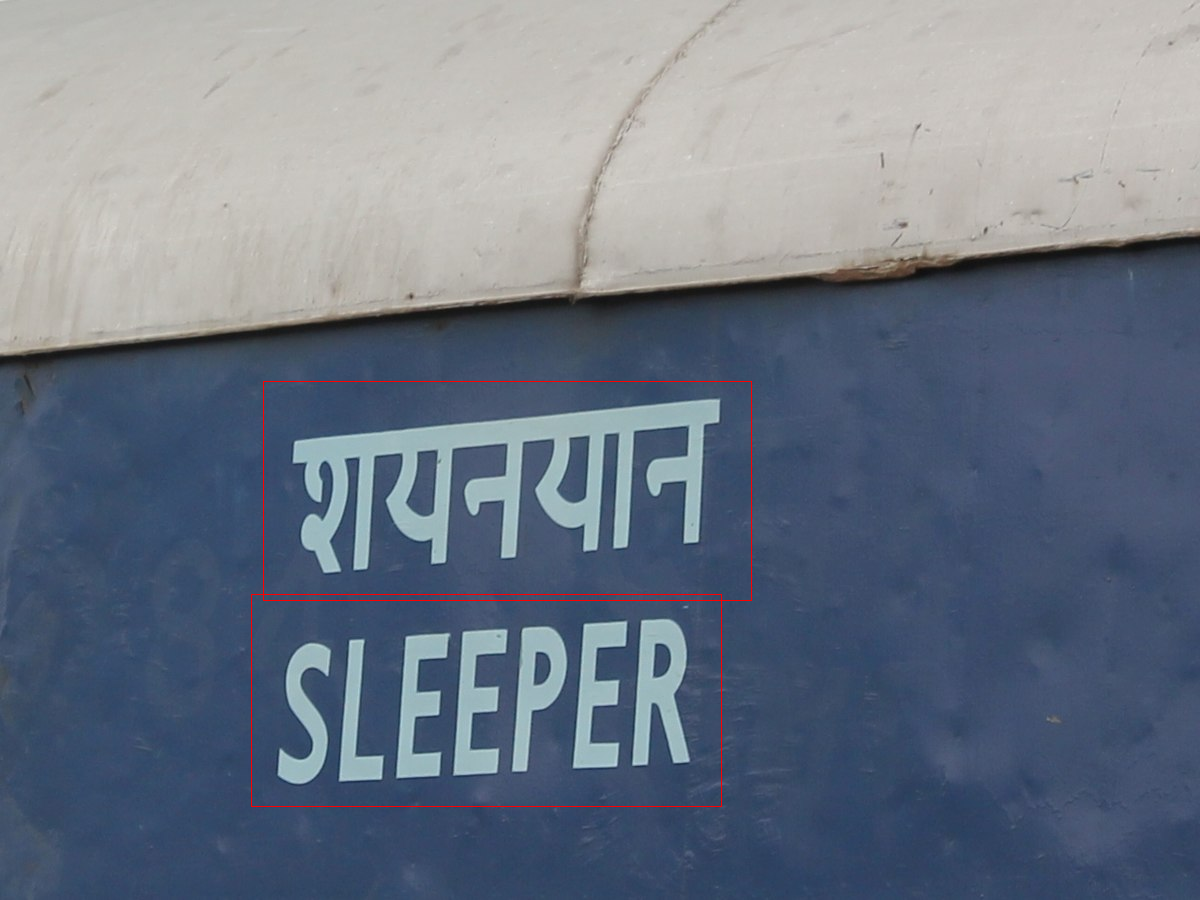

In [ ]:
# %%

img_pil, cropped_imgs, ocr_result = detect_text(SAMPLE_IMG_PATH)
img_pil

In [ ]:
# %%

def recognize_img(pil_img, input_img_size=(100, 32)):
    # TODO: 잘려진 단어 이미지를 인식하는 코드를 작성하세요!

    # PIL 이미지를 numpy 배열로 변환
    img_np = np.array(pil_img)
    # 인식 모델 입력 크기에 맞게 이미지 크기 조정
    img_resized = cv2.resize(img_np, input_img_size)

    # detail=0 옵션은 인식 결과의 텍스트만 반환합니다.
    result = reader.readtext(img_resized, detail=0, paragraph=False)

    if result:
        recognized_text = result[0]
    else:
        recognized_text = ""

    print("Recognized text:", recognized_text)
    return recognized_text

In [ ]:
# %%

# 기존 EasyOCR 결과 확인
print("🔍 EasyOCR 결과:")
img_pil, cropped_imgs, ocr_result = detect_text(SAMPLE_IMG_PATH)
print(f"검출된 텍스트 개수: {len(ocr_result)}")
for i, (bbox, text, conf) in enumerate(ocr_result):
    print(f"[{i+1}] '{text}' (신뢰도: {conf:.3f})")

🔍 EasyOCR 결과:
검출된 텍스트 개수: 2
[1] '147417' (신뢰도: 0.205)
[2] 'SLEEPER' (신뢰도: 1.000)


In [ ]:
# %%

# 모든 OCR 모델 비교
print("\n" + "="*50)
print("🚀 모든 OCR 모델 비교 테스트")
print("="*50)

# OCR 모델 비교 실행 (CRNN 모델 포함)
results = compare_ocr_models(SAMPLE_IMG_PATH, model, label_converter, device)


🚀 모든 OCR 모델 비교 테스트
🔍 OCR 모델 성능 비교 분석 (EasyOCR vs Tesseract vs CRNN)

1️⃣ EasyOCR 결과:
   검출된 텍스트 개수: 2
   [1] '147417' (신뢰도: 0.205)
   [2] 'SLEEPER' (신뢰도: 1.000)

2️⃣ Tesseract OCR 결과:
   검출된 텍스트 개수: 1
   [1] 'SLEEPER' (신뢰도: 0.940)

3️⃣ CRNN 모델 결과:
   검출된 텍스트 개수: 1
   [1] 'S' (신뢰도: 0.800)

📊 시각화 결과:
빨간색: EasyOCR, 초록색: Tesseract, 보라색: CRNN



📝 개별 모델 테스트:

1️⃣ EasyOCR만 사용:
EasyOCR 결과 이미지:


/Users/gwanghunlee/ocr/.venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gwanghunlee/ocr/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 44208 (\N{HANGUL SYLLABLE GYEOL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/gwanghunlee/ocr/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 44284 (\N{HANGUL SYLLABLE GWA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/gwanghunlee/ocr/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/gwanghunlee/ocr/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph

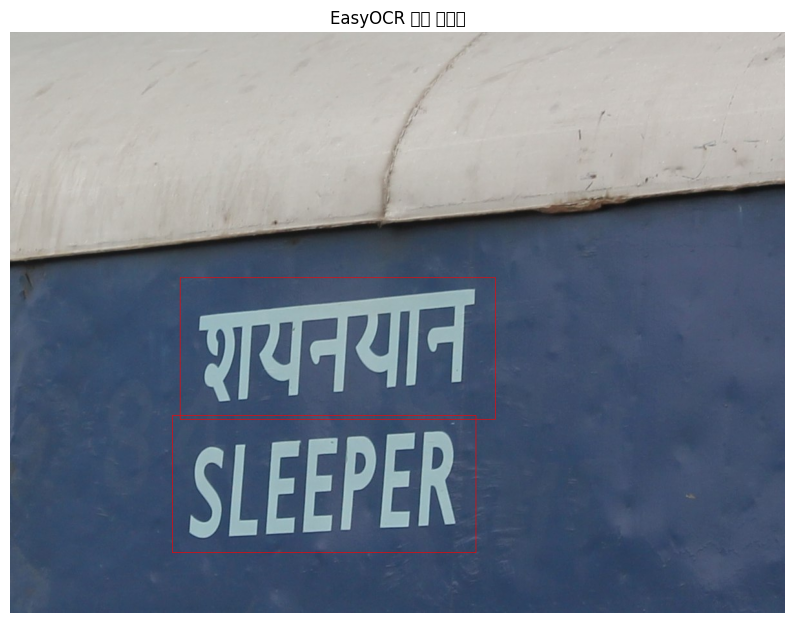


2️⃣ Tesseract OCR만 사용:
Tesseract OCR 결과 이미지:


/Users/gwanghunlee/ocr/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 44208 (\N{HANGUL SYLLABLE GYEOL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/gwanghunlee/ocr/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 44284 (\N{HANGUL SYLLABLE GWA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/gwanghunlee/ocr/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/gwanghunlee/ocr/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 48120 (\N{HANGUL SYLLABLE MI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/gwanghunlee/ocr/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 51648 (\N{HANGUL SYLLABL

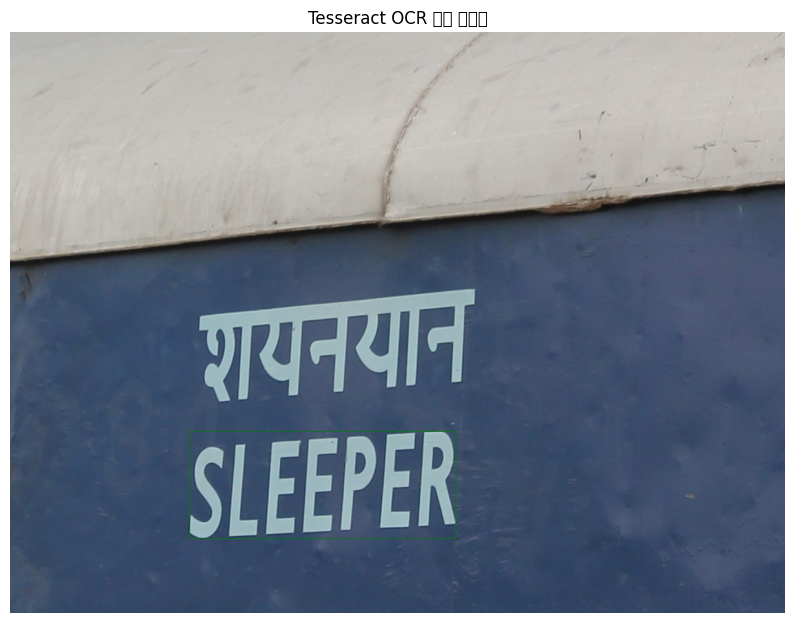


3️⃣ CRNN 모델만 사용:
CRNN 모델 결과 이미지:


/Users/gwanghunlee/ocr/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 47784 (\N{HANGUL SYLLABLE MO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/gwanghunlee/ocr/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 45944 (\N{HANGUL SYLLABLE DEL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


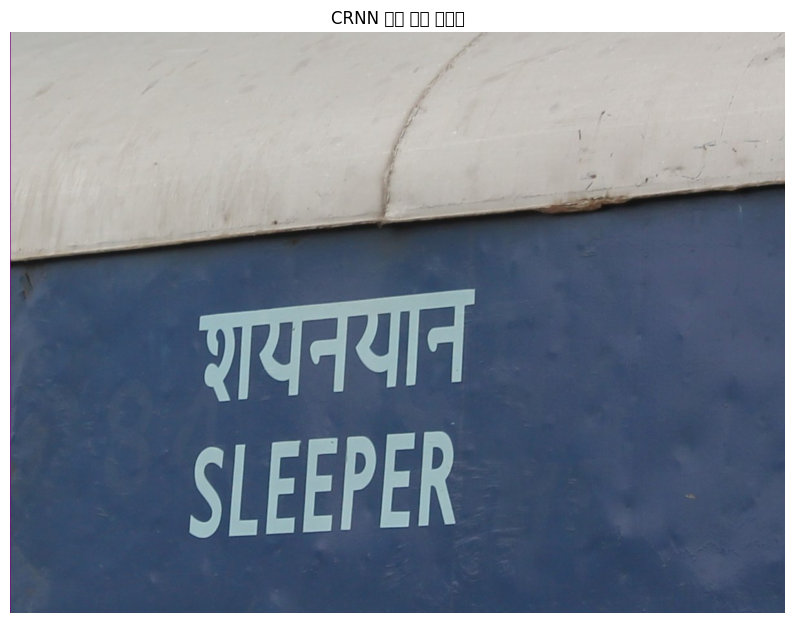

In [ ]:
# %%

# 개별 모델 테스트 예제
# 이 코드는 EasyOCR와 Tesseract OCR을 각각 사용하여 이미지를 처리하고,
# 결과 이미지를 시각적으로 확인할 수 있도록 matplotlib을 활용하여 출력합니다.

import matplotlib.pyplot as plt

print("\n📝 개별 모델 테스트:")

# 1️⃣ EasyOCR만 사용
print("\n1️⃣ EasyOCR만 사용:")
img_easy, crops_easy, result_easy = detect_text(SAMPLE_IMG_PATH)
print("EasyOCR 결과 이미지:")

# EasyOCR 결과 이미지를 시각화합니다.
plt.figure(figsize=(10, 8))
plt.imshow(img_easy)
plt.title("EasyOCR 결과 이미지")
plt.axis('off')  # 축을 숨깁니다.
plt.show()

# 2️⃣ Tesseract OCR만 사용
print("\n2️⃣ Tesseract OCR만 사용:")
img_tess, crops_tess, result_tess = detect_text_tesseract(SAMPLE_IMG_PATH)
print("Tesseract OCR 결과 이미지:")

# Tesseract OCR 결과 이미지를 시각화합니다.
plt.figure(figsize=(10, 8))
plt.imshow(img_tess)
plt.title("Tesseract OCR 결과 이미지")
plt.axis('off')  # 축을 숨깁니다.
plt.show()

# CRNN 모델 단독 성능 비교 테스트 코드
# 이 코드는 CRNN(Convolutional Recurrent Neural Network) 기반 OCR 모델만을 사용하여
# 입력 이미지를 처리하고, 결과 이미지를 시각적으로 확인할 수 있도록 matplotlib을 활용하여 출력합니다.
# CRNN 모델은 주로 딥러닝 기반의 문자 인식에 사용되며, 이미지 내의 텍스트를 시퀀스 형태로 예측합니다.

print("\n3️⃣ CRNN 모델만 사용:")

# detect_text_crnn 함수는 CRNN 모델을 이용해 이미지에서 텍스트를 검출하고,
# 결과 이미지, 크롭된 단어 이미지 리스트, 인식 결과 리스트를 반환합니다.
img_crnn, crops_crnn, result_crnn = detect_text_crnn(SAMPLE_IMG_PATH, model, label_converter, device)
print("CRNN 모델 결과 이미지:")

# CRNN 모델의 결과 이미지를 시각화합니다.
# plt.figure를 통해 새로운 그림을 만들고, imshow로 이미지를 표시합니다.
# title로 그래프 제목을 지정하고, axis('off')로 축을 숨겨서 이미지에만 집중할 수 있게 합니다.
plt.figure(figsize=(10, 8))
plt.imshow(img_crnn)
plt.title("CRNN 모델 결과 이미지")
plt.axis('off')  # 축을 숨깁니다.
plt.show()